In [1]:
using Revise
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using LinearAlgebra
using CSV
using StatsBase
include("utils.jl")
include("financial_bvar_temp.jl")
using .FinancialBVAR

In [2]:
df = DataFrame(XLSX.readtable("usa_var_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.quarter, last)

292×11 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬────────┬─────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E      │ CAPE   ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼────────┼─────────
│ 1951-12-01 │  0.02513 │   104.098 │       24.19 │  1.41333 │   2.44 │ 12.527 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       23.74 │     1.43 │    2.4 │ 12.242 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       25.08 │     1.45 │   2.34 │ 12.669 ⋯
│ 1952-09-01 │  0.02685 │   104.468 │       24.26 │  1.43667 │   2.36 │ 12.131 ⋯
│ 1952-12-01 │  0.02547 │   106.402 │       26.18 │     1.41 │    2.4 │ 13.010 ⋯
│ 1953-03-01 │  0.02735 │   105.373 │       24.71 │  1.41333 │   2.43 │ 12.163 ⋯
│ 1953-06-01 │  0.02987 │    103.86 │       24.29 │     1.42 │   2.51 │ 11.750 ⋯
│ 1953-09-01 │  0.02636 │    107.81 │       23.97 │     1.43 │   2.55 │ 11.391 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [3]:
colnames(data_source)

11-element Vector{Symbol}:
 :Yeld_10Y
 :Price_10Y
 :Stock_Price
 :Dividend
 :E
 :CAPE
 :T_Bill
 :CPI
 :Dividend_Yeld
 :Total_Stock_2
 :Total_Stock

In [4]:
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns = merge(returns, log1p.(data_source[:T_Bill])./4)
cpi = percentchange(data_source[:CPI], :log)
real_returns = returns .- cpi
term = data_source[:Yeld_10Y] ./4 .- data_source[:T_Bill] ./4
dy = data_source[:Dividend_Yeld] #log.(data_source[:Dividend_Yeld])
data = merge(real_returns, dy, term, cpi)

291×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-03-01 to 2024-07-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1952-03-01 │      1.98335e-5 │     0.0107337 │  0.00772445 │     0.0602359 │ ⋯
│ 1952-06-01 │       0.0581411 │    0.00263202 │ -0.00708528 │      0.057815 │ ⋯
│ 1952-09-01 │      -0.0185027 │    -0.0173351 │  0.00423886 │     0.0592197 │ ⋯
│ 1952-12-01 │       0.0932838 │     0.0220972 │   0.0089235 │     0.0538579 │ ⋯
│ 1953-03-01 │      -0.0437093 │   -0.00972202 │  0.00497517 │     0.0571967 │ ⋯
│ 1953-06-01 │      -0.0100139 │    -0.0219485 │ -0.00227055 │     0.0584603 │ ⋯
│ 1953-09-01 │     -0.00574595 │     0.0298874 │ -0.00299956 │     0.0596579 │ ⋯
│ 1953-12-01 │        0.078226 │     0.0248173 │  0.00767892 │     0.0572141 │ ⋯
│     ⋮      │        ⋮        │ 

In [5]:
CSV.write("usa_data_transformed.csv", data)

"usa_data_transformed.csv"

In [6]:
start = Date(1983,03,01)
end_d = Date(2019, 12, 31)
s_data = to(from(data, start),end_d)

148×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1983-03-01 to 2019-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1983-03-01 │       0.0916672 │    0.00192869 │   0.0119025 │     0.0438808 │ ⋯
│ 1983-06-01 │       0.0544534 │    -0.0072674 │  0.00796388 │     0.0416766 │ ⋯
│ 1983-09-01 │      0.00376823 │    -0.0107314 │   0.0105936 │     0.0419201 │ ⋯
│ 1983-12-01 │     -0.00592333 │   -0.00188541 │    0.012673 │     0.0427885 │ ⋯
│ 1984-03-01 │      -0.0544437 │    -0.0222866 │   0.0110268 │     0.0458333 │ ⋯
│ 1984-06-01 │      -0.0397357 │    -0.0482265 │   0.0138793 │      0.048533 │ ⋯
│ 1984-09-01 │       0.0861884 │     0.0948199 │   0.0132056 │      0.045085 │ ⋯
│ 1984-12-01 │       0.0496119 │     0.0795741 │   0.0174816 │     0.0441336 │ ⋯
│     ⋮      │        ⋮        │ 

In [7]:
returns_summarystats(to(from(returns, start),end_d), 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1371,0.7827,0.1081,0.2693,-1.0147,-0.8517,-0.0057,0.137,2.0354,0.7885,0.1463
Price_10Y,0.0833,0.5691,0.0704,0.1747,-0.2868,0.4522,-0.0411,0.0503,0.0835,0.8451,0.0465
T_Bill,0.0135,0.0987,0.0349,0.0543,0.0001,0.2748,0.0094,0.9738,-0.9875,2.5867,0.0352


In [8]:
returns_summarystats(s_data, 1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.0686,0.1938,0.0205,0.0609,-0.2381,-0.7125,-0.01,0.1159,1.6044,0.2982,0.0281
Price_10Y_CPI,0.0439,0.1677,0.011,0.0381,-0.0763,0.5516,-0.0198,0.0387,0.5188,0.2517,0.0057
T_Bill_CPI,0.008,0.0255,0.0022,0.0076,-0.0208,-0.1359,-0.0028,0.2722,0.479,0.2718,0.0033
Dividend_Yeld,0.0087,0.0485,0.0238,0.0298,0.0113,0.8748,0.0178,0.9596,-0.0527,2.7444,0.0205
Yeld_10Y_T_Bill,0.0028,0.0099,0.0046,0.0068,-0.0016,-0.1846,0.0024,0.8688,-0.9357,1.672,0.0048
CPI,0.0069,0.0236,0.0066,0.0101,-0.0254,-0.9021,0.0033,-0.0038,3.5024,0.9487,0.007


In [9]:
returns_summarystats(s_data, 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.1372,0.7753,0.0819,0.2437,-0.9526,-0.7125,-0.0402,0.1159,1.6044,0.5964,0.1126
Price_10Y_CPI,0.0877,0.6707,0.0442,0.1522,-0.3051,0.5516,-0.0792,0.0387,0.5188,0.5034,0.023
T_Bill_CPI,0.016,0.1019,0.0087,0.0304,-0.0832,-0.1359,-0.0113,0.2722,0.479,0.5436,0.0131
Dividend_Yeld,0.0173,0.1941,0.0951,0.1192,0.045,0.8748,0.0712,0.9596,-0.0527,5.4888,0.0821
Yeld_10Y_T_Bill,0.0055,0.0397,0.0184,0.0271,-0.0065,-0.1846,0.0096,0.8688,-0.9357,3.344,0.0192
CPI,0.0138,0.0946,0.0262,0.0405,-0.1016,-0.9021,0.0134,-0.0038,3.5024,1.8974,0.0281


In [10]:
#returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns1y = from(to(percentchange(collapse(data_source[:Total_Stock, :Price_10Y],year, last), :log),end_d),start)
returns_summarystats(returns1y,1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.1594,0.302,0.1081,0.2337,-0.4393,-1.3222,0.0116,0.004,2.1181,0.6781,0.1447
Price_10Y,0.0891,0.2605,0.0704,0.1386,-0.1063,-0.0199,0.0112,-0.2057,-0.5325,0.79,0.0698


In [11]:
returns1y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],4) ./1
returns3y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],12) ./3
returns5y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],20) ./5
returns10y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],40) ./10
cum_returns = merge(TimeSeries.rename!(returns1y, [:RealStock1y, :RealBonds1y, :RealTBill1y]), 
                    TimeSeries.rename!(returns3y, [:RealStock3y, :RealBonds3y, :RealTBill3y]), 
                    TimeSeries.rename!(returns5y, [:RealStock5y, :RealBonds5y, :RealTBill5y]),
                    TimeSeries.rename!(returns10y, [:RealStock10y, :RealBonds10y, :RealTBill10y]))
returns_summarystats(expm1.(cum_returns),1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
RealStock1y,0.1613,0.4579,0.0862,0.1897,-0.3789,-0.6888,0.0144,0.789,0.7594,0.5346,0.0994
RealBonds1y,0.077,0.221,0.0367,0.0986,-0.1238,0.0019,-0.0171,0.6542,-0.7006,0.4762,0.0357
RealTBill1y,0.0179,0.0353,0.0016,0.0191,-0.034,0.1339,-0.0133,0.9005,-1.0945,0.0871,0.0001
RealStock3y,0.1056,0.2948,0.0787,0.133,-0.1598,-0.3309,0.006,0.949,-0.1926,0.7452,0.0989
RealBonds3y,0.0343,0.1294,0.0367,0.0616,-0.0339,0.2055,0.0119,0.8043,-0.5854,1.0708,0.0378
RealTBill3y,0.0151,0.0279,0.0022,0.014,-0.0241,0.215,-0.0096,0.9775,-1.1669,0.1429,-0.0002
RealStock5y,0.0812,0.2456,0.0756,0.1291,-0.0611,0.0281,-0.0016,0.9579,-0.9165,0.9305,0.0925
RealBonds5y,0.0235,0.0904,0.0393,0.0568,-0.009,-0.1967,0.0206,0.8578,-0.655,1.6707,0.0411
RealTBill5y,0.014,0.0259,0.0033,0.0152,-0.0201,0.1422,-0.0101,0.9823,-1.3221,0.2363,0.0015
RealStock10y,0.0504,0.158,0.0731,0.1085,-0.0516,-0.5112,0.0491,0.973,-0.2183,1.4513,0.0748


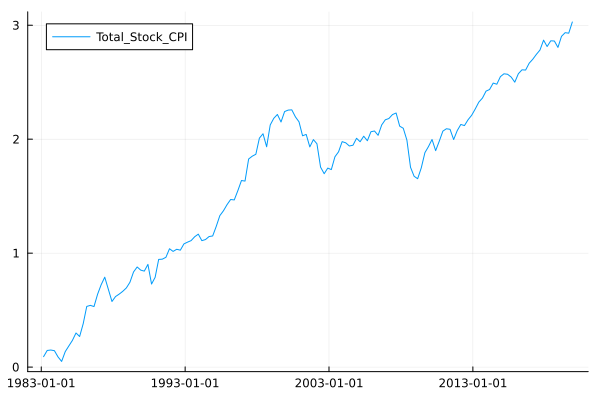

In [12]:
plot(cumsum(s_data[:Total_Stock_CPI]))

In [13]:
vmodel = VARModel(s_data)
model_summary(vmodel)

,const,Total_Stock_CPI,Price_10Y_CPI,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI,std
Total_Stock_CPI,-0.0029,0.1211,0.0789,-2.3969,2.8275,-5.5279,-2.5739,0.0671
Price_10Y_CPI,-0.0042,-0.1575,0.0565,2.2873,-0.8146,3.9952,2.0832,0.0418
T_Bill_CPI,-0.004,-0.0216,0.0029,0.6895,-0.0056,0.0102,0.7775,0.0063
Dividend_Yeld,0.0007,-0.0034,-0.0026,0.0403,0.9351,0.0784,0.0515,0.0017
Yeld_10Y_T_Bill,0.0001,0.0013,0.0054,-0.0442,0.0274,0.8451,-0.0161,0.0013
CPI,0.004,0.0244,-0.0098,0.3028,0.0032,0.0394,0.1964,0.0065


,Total_Stock_CPI,Price_10Y_CPI,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI
Total_Stock_CPI,1.0,0.04,0.13,-0.9,-0.12,-0.12
Price_10Y_CPI,0.04,1.0,0.38,-0.1,-0.61,-0.44
T_Bill_CPI,0.13,0.38,1.0,-0.03,-0.16,-0.99
Dividend_Yeld,-0.9,-0.1,-0.03,1.0,0.16,0.03
Yeld_10Y_T_Bill,-0.12,-0.61,-0.16,0.16,1.0,0.09
CPI,-0.12,-0.44,-0.99,0.03,0.09,1.0


In [14]:
bmodel = NormalWishartBVAR(s_data)
sample_posterior!(bmodel,10000, 2000)
posterior_summary(bmodel)

"Total_Stock_CPI coefficients"

Quantiles
       parameters       2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol    Float64   Float64   Float64   Float64   Float64 

            const    -0.0381   -0.0148   -0.0029    0.0086    0.0319
  Total_Stock_CPI    -0.0442    0.0627    0.1201    0.1774    0.2882
    Price_10Y_CPI    -0.2187   -0.0218    0.0781    0.1820    0.3794
       T_Bill_CPI    -5.0744   -3.3081   -2.3905   -1.4800    0.2194
    Dividend_Yeld     0.7322    2.1156    2.8340    3.5748    4.9170
  Yeld_10Y_T_Bill   -11.1894   -7.4669   -5.5320   -3.6436   -0.0808
              CPI    -5.3985   -3.5625   -2.5571   -1.5929    0.3134


"Price_10Y_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0263   -0.0119   -0.0045    0.0031    0.0177
  Total_Stock_CPI   -0.2599   -0.1922   -0.1575   -0.1228   -0.0558
    Price_10Y_CPI   -0.1289   -0.0070    0.0581    0.1188    0.2406
       T_Bill_CPI    0.6495    1.7284    2.2828    2.8322    3.9315
    Dividend_Yeld   -2.1228   -1.2548   -0.8082   -0.3459    0.5139
  Yeld_10Y_T_Bill    0.5330    2.8240    3.9547    5.1432    7.3393
              CPI    0.3210    1.4661    2.0920    2.6936    3.8845


"T_Bill_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0075   -0.0052   -0.0040   -0.0029   -0.0008
  Total_Stock_CPI   -0.0372   -0.0269   -0.0216   -0.0162   -0.0061
    Price_10Y_CPI   -0.0246   -0.0063    0.0032    0.0127    0.0314
       T_Bill_CPI    0.4380    0.6019    0.6896    0.7742    0.9409
    Dividend_Yeld   -0.2019   -0.0715   -0.0049    0.0644    0.1956
  Yeld_10Y_T_Bill   -0.5107   -0.1741    0.0045    0.1875    0.5242
              CPI    0.5056    0.6824    0.7765    0.8710    1.0435


"Dividend_Yeld coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0002    0.0004    0.0007    0.0010    0.0016
  Total_Stock_CPI   -0.0075   -0.0048   -0.0033   -0.0019    0.0008
    Price_10Y_CPI   -0.0103   -0.0052   -0.0026   -0.0000    0.0049
       T_Bill_CPI   -0.0279    0.0176    0.0399    0.0638    0.1095
    Dividend_Yeld    0.8818    0.9163    0.9349    0.9531    0.9889
  Yeld_10Y_T_Bill   -0.0613    0.0306    0.0787    0.1274    0.2217
              CPI   -0.0225    0.0268    0.0513    0.0767    0.1237


"Yeld_10Y_T_Bill coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0005   -0.0001    0.0001    0.0004    0.0009
  Total_Stock_CPI   -0.0019    0.0002    0.0013    0.0025    0.0046
    Price_10Y_CPI   -0.0004    0.0034    0.0054    0.0074    0.0114
       T_Bill_CPI   -0.0987   -0.0634   -0.0445   -0.0266    0.0087
    Dividend_Yeld   -0.0146    0.0128    0.0277    0.0417    0.0701
  Yeld_10Y_T_Bill    0.7367    0.8078    0.8456    0.8831    0.9524
              CPI   -0.0719   -0.0360   -0.0166    0.0031    0.0401


"CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const    0.0006    0.0028    0.0040    0.0051    0.0075
  Total_Stock_CPI    0.0083    0.0190    0.0245    0.0299    0.0402
    Price_10Y_CPI   -0.0386   -0.0197   -0.0102   -0.0004    0.0184
       T_Bill_CPI    0.0473    0.2152    0.3038    0.3926    0.5607
    Dividend_Yeld   -0.2064   -0.0695    0.0025    0.0715    0.2072
  Yeld_10Y_T_Bill   -0.4893   -0.1393    0.0447    0.2288    0.5751
              CPI   -0.0760    0.1011    0.1969    0.2954    0.4773


"correlation matrix"

Quantiles
                       parameters      2.5%     25.0%     50.0%     75.0%      ⋯
                           Symbol   Float64   Float64   Float64   Float64   Fl ⋯

  Total_Stock_CPI_Total_Stock_CPI    0.0609    0.0658    0.0684    0.0713    0 ⋯
    Total_Stock_CPI_Price_10Y_CPI   -0.1344   -0.0238    0.0336    0.0912    0 ⋯
       Total_Stock_CPI_T_Bill_CPI   -0.0378    0.0731    0.1302    0.1869    0 ⋯
    Total_Stock_CPI_Dividend_Yeld   -0.9300   -0.9138   -0.9034   -0.8919   -0 ⋯
  Total_Stock_CPI_Yeld_10Y_T_Bill   -0.2768   -0.1745   -0.1178   -0.0593    0 ⋯
              Total_Stock_CPI_CPI   -0.2742   -0.1722   -0.1168   -0.0590    0 ⋯
    Price_10Y_CPI_Total_Stock_CPI   -0.1344   -0.0238    0.0336    0.0912    0 ⋯
      Price_10Y_CPI_Price_10Y_CPI    0.0380    0.0409    0.0426    0.0445    0 ⋯
         Price_10Y_CPI_T_Bill_CPI    0.2265    0.3293    0.3805    0.4280    0 ⋯
      Price_10Y_CPI_Dividend_Yeld   -0.2576   -0.1530   -0.0940   -0.0381    0 ⋯
    Price_10Y_CPI

In [15]:
assets_names = colnames(s_data)
scenarios = simulate(vmodel,60)

for n in 1:6
    s_ann = annualise(scenarios[n,:,2:end],4)
    print_percentiles(s_ann,[0.05, 0.25, 0.5, 0.75, 0.95], string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0954752,-0.144444,-0.164863,-0.178132,-0.173352,-0.171131,-0.173411,-0.177654,-0.178656,-0.171396,-0.17794,-0.175753,-0.175806,-0.172755,-0.178388
0.25,0.0331354,-0.00702511,-0.0244425,-0.0313596,-0.0363726,-0.0320834,-0.0293628,-0.0343419,-0.0356533,-0.0345905,-0.0341186,-0.0336563,-0.0322258,-0.0352184,-0.0352435
0.5,0.126719,0.0884615,0.0755705,0.0644447,0.0652057,0.0637838,0.0679775,0.0620784,0.0634171,0.064898,0.0628376,0.0676642,0.0639517,0.0659698,0.0635474
0.75,0.217642,0.18514,0.172902,0.164776,0.166694,0.161707,0.163424,0.158564,0.162898,0.16279,0.162542,0.162622,0.163755,0.164117,0.162064
0.95,0.351334,0.320825,0.316097,0.308975,0.30329,0.30351,0.306334,0.301116,0.302704,0.30147,0.305278,0.304533,0.305247,0.310313,0.307005


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.177211,-0.14619,-0.141176,-0.134345,-0.133634,-0.129562,-0.12952,-0.132438,-0.130274,-0.133837,-0.134399,-0.132332,-0.130073,-0.132193,-0.134067
0.25,-0.101986,-0.0662325,-0.0577323,-0.0510911,-0.0487189,-0.0465125,-0.0486025,-0.0485056,-0.0465293,-0.047209,-0.0490041,-0.0477656,-0.0469534,-0.0481783,-0.0490615
0.5,-0.0520239,-0.0113932,0.000161742,0.00735859,0.0101676,0.0112268,0.0102707,0.0113315,0.0113924,0.0108031,0.0117121,0.0112634,0.0120214,0.0125033,0.0114569
0.75,-0.00147997,0.0452771,0.0581801,0.0631671,0.070053,0.0683404,0.068901,0.0712906,0.071386,0.0704998,0.0695237,0.0703144,0.0716988,0.0715786,0.0692287
0.95,0.072437,0.122614,0.14056,0.148155,0.154149,0.152219,0.151388,0.155948,0.155966,0.152818,0.154179,0.154875,0.156195,0.157709,0.15247


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0272474,-0.0274551,-0.029449,-0.0311206,-0.0320501,-0.0337623,-0.0339609,-0.034305,-0.0350685,-0.0352329,-0.0352645,-0.0356328,-0.0356905,-0.0354872,-0.0361969
0.25,-0.0162235,-0.0142218,-0.0151047,-0.0157853,-0.0160604,-0.0170819,-0.0175164,-0.017546,-0.0181488,-0.0180897,-0.0179676,-0.0181599,-0.0181516,-0.0180569,-0.0184842
0.5,-0.00791259,-0.00489342,-0.005129,-0.00496,-0.00506236,-0.00509419,-0.00599055,-0.00618512,-0.00618755,-0.00597945,-0.0061378,-0.00608855,-0.00635315,-0.00599414,-0.00615225
0.75,0.000322415,0.00442111,0.00536122,0.00533929,0.00587399,0.00611201,0.00563716,0.00571139,0.00567114,0.00571799,0.00555717,0.00618916,0.00590106,0.00590645,0.0058998
0.95,0.0119471,0.0174901,0.0200163,0.0209351,0.0213233,0.021947,0.0224189,0.0233313,0.0230002,0.0224026,0.0234132,0.0235037,0.0235765,0.0237542,0.023605


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,0.0532359,0.0417825,0.036782,0.0341457,0.0329249,0.0314761,0.0303415,0.0300307,0.0300651,0.0289249,0.0295799,0.0294592,0.0292499,0.029215,0.0287146
0.25,0.062104,0.0569485,0.0547008,0.0536788,0.0530329,0.0527696,0.0527953,0.0528031,0.0530852,0.0531565,0.0527349,0.0531881,0.0531333,0.053047,0.0530829
0.5,0.0688044,0.0673269,0.0670402,0.0669014,0.0675028,0.0679908,0.0677546,0.068213,0.0687735,0.0690132,0.0692702,0.0695514,0.0695262,0.0695338,0.0697074
0.75,0.0752874,0.0777533,0.079327,0.080834,0.0819104,0.0828231,0.0834165,0.0840216,0.0847254,0.0847507,0.0855328,0.085462,0.0859335,0.0863732,0.0867862
0.95,0.0845158,0.092907,0.0971856,0.101366,0.103766,0.105131,0.10641,0.106212,0.107304,0.108078,0.108501,0.109528,0.110482,0.110919,0.110685


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.00191871,-0.00256042,-0.00171314,-0.00183514,-0.00154756,-0.00156459,-0.00123854,-0.00124378,-0.0012387,-0.00084228,-0.000923982,-0.000849203,-0.00084885,-0.000855243,-0.00061675
0.25,0.00350608,0.0054649,0.00694737,0.00778751,0.00816032,0.00837628,0.00882573,0.00913005,0.00920621,0.0094448,0.00937342,0.00943408,0.00949637,0.00935648,0.00968442
0.5,0.00741264,0.0111491,0.0131963,0.0143573,0.0150753,0.0155313,0.0158721,0.0162531,0.0163879,0.0164431,0.0164395,0.0165968,0.0166922,0.0166591,0.0168049
0.75,0.0113806,0.0167276,0.0195064,0.021068,0.0220346,0.0226559,0.0231325,0.0234965,0.0234321,0.0235353,0.0236258,0.0237279,0.0239504,0.023924,0.0239126
0.95,0.017022,0.0249921,0.0286257,0.0304214,0.0314839,0.0325823,0.0331583,0.0334692,0.0338257,0.0339211,0.0340969,0.034364,0.0343459,0.0340932,0.0344175


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,0.0040586,0.000282532,-7.87103e-5,-0.000903178,-0.00167832,-0.00169353,-0.00154668,-0.00164691,-0.00214,-0.00177999,-0.00200396,-0.00211308,-0.00190785,-0.00221566,-0.00209181
0.25,0.016079,0.0127595,0.0120188,0.011966,0.0115996,0.0115566,0.0112487,0.011161,0.0112092,0.0111757,0.011235,0.0111314,0.0112374,0.0108928,0.0111127
0.5,0.0244973,0.0214433,0.0208883,0.0207561,0.0206849,0.0203011,0.0204823,0.0203405,0.0203453,0.0202813,0.0204276,0.0203435,0.0201945,0.0201045,0.0203214
0.75,0.032844,0.0298786,0.0296477,0.0296837,0.0294641,0.0295193,0.0295916,0.0295731,0.0296756,0.029689,0.02959,0.0294797,0.0294808,0.029167,0.0297039
0.95,0.0452119,0.042703,0.042661,0.042842,0.0424944,0.0424437,0.042626,0.0428431,0.0427825,0.0426576,0.0427741,0.0428222,0.0428347,0.0423358,0.0431675


In [16]:
scenarios_b = simulate(bmodel,60, 10)
for n in 1:6
    s_ann = annualise(scenarios_b[n,:,2:end],4)
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.143275,-0.445013,-0.507505,-0.522948,-0.535617,-0.546361,-0.546959,-0.554667,-0.550554,-0.560336,-0.556634,-0.568588,-0.571848,-0.566428,-0.574342
0.25,0.0412459,-0.0500248,-0.0760753,-0.0828817,-0.0884154,-0.0902608,-0.0920301,-0.0927557,-0.0920491,-0.092449,-0.0946149,-0.0955943,-0.0952888,-0.0965867,-0.0949758
0.5,0.114692,0.0802366,0.0709737,0.0675069,0.0661312,0.0673559,0.0667433,0.0663826,0.0677986,0.0678667,0.0668404,0.0667147,0.0672405,0.0674871,0.0668516
0.75,0.203826,0.219295,0.219289,0.218923,0.222134,0.224132,0.226561,0.227034,0.227981,0.229356,0.230398,0.230468,0.232319,0.23252,0.232705
0.98,0.466642,0.641146,0.666207,0.669035,0.671813,0.67919,0.686455,0.697225,0.701669,0.710317,0.715702,0.716176,0.722156,0.729668,0.735039


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.29494,-0.456611,-0.490291,-0.495984,-0.500879,-0.510179,-0.520291,-0.523009,-0.525234,-0.526815,-0.528408,-0.531726,-0.534838,-0.537119,-0.53578
0.25,-0.113549,-0.136146,-0.14029,-0.14177,-0.1448,-0.147084,-0.149019,-0.151385,-0.151083,-0.154555,-0.156256,-0.155777,-0.155584,-0.156186,-0.157322
0.5,-0.0446667,-0.00763045,0.0037614,0.00897177,0.0112145,0.0123508,0.0124334,0.0126907,0.0116426,0.0117668,0.0125218,0.0134988,0.0141698,0.0124805,0.0125019
0.75,0.0159801,0.117154,0.147163,0.15906,0.167181,0.170676,0.172982,0.173273,0.174449,0.176939,0.179974,0.181085,0.181608,0.182512,0.182411
0.98,0.161511,0.425331,0.493856,0.512389,0.529158,0.540604,0.546353,0.552721,0.554116,0.557549,0.558802,0.560479,0.565243,0.563318,0.563215


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0631911,-0.103609,-0.125158,-0.140393,-0.152636,-0.164411,-0.172024,-0.180728,-0.188773,-0.195875,-0.202157,-0.207582,-0.214644,-0.221881,-0.226647
0.25,-0.0247404,-0.0347842,-0.0410411,-0.0454054,-0.049206,-0.0519375,-0.053921,-0.0555958,-0.0572845,-0.0591302,-0.0605411,-0.0613031,-0.0614696,-0.062535,-0.063593
0.5,-0.00764885,-0.00459889,-0.00411664,-0.00439451,-0.00464344,-0.00464139,-0.00489869,-0.00544832,-0.0055895,-0.00569648,-0.00574198,-0.00592971,-0.00608662,-0.00626634,-0.00600089
0.75,0.00950131,0.025633,0.0326191,0.0369101,0.0401009,0.0416277,0.0433361,0.0444476,0.0459277,0.0470324,0.0475157,0.048076,0.0489442,0.0490988,0.0497657
0.98,0.0463099,0.0920727,0.114482,0.12985,0.140361,0.150744,0.158152,0.165287,0.169991,0.175177,0.180046,0.18543,0.189801,0.193899,0.197455


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,0.0173711,-0.0211403,-0.0491763,-0.0711833,-0.0902701,-0.105322,-0.1195,-0.132681,-0.146152,-0.157873,-0.170113,-0.17934,-0.192076,-0.201991,-0.213099
0.25,0.0520471,0.039403,0.0320744,0.0267475,0.0228377,0.0195463,0.0166483,0.0141892,0.0127316,0.0116735,0.00977918,0.00876524,0.00713869,0.00600279,0.00459995
0.5,0.0684383,0.0670653,0.0674492,0.0683525,0.0686743,0.0687276,0.0691291,0.0697472,0.0698519,0.070158,0.0701942,0.0702907,0.0702943,0.0705323,0.070361
0.75,0.0848038,0.0949631,0.102732,0.10829,0.113091,0.117057,0.120107,0.122637,0.124594,0.126935,0.128227,0.129407,0.130975,0.131952,0.132671
0.98,0.11948,0.154426,0.179092,0.199028,0.214989,0.229864,0.244074,0.253797,0.263354,0.272292,0.282406,0.29098,0.298336,0.305423,0.313069


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0392859,-0.0587578,-0.0667945,-0.0720087,-0.0766693,-0.0803689,-0.0836656,-0.0883939,-0.0908633,-0.0942659,-0.0964712,-0.0991528,-0.101957,-0.10467,-0.10782
0.25,-0.00730998,-0.0101862,-0.0111271,-0.0114126,-0.0118603,-0.0122999,-0.0124219,-0.0127142,-0.0131082,-0.0131695,-0.0133884,-0.0136545,-0.0136975,-0.0140901,-0.0145478
0.5,0.00750996,0.0111262,0.0129483,0.0140309,0.01503,0.015302,0.0156072,0.0156638,0.0158301,0.0162199,0.0164178,0.01648,0.0164655,0.0164285,0.0165136
0.75,0.0220932,0.0321643,0.0367454,0.0394106,0.0412888,0.0427306,0.0434639,0.0441978,0.0446121,0.045185,0.0460892,0.046309,0.0464166,0.0467882,0.0470658
0.98,0.0532935,0.0783894,0.0899985,0.0980462,0.103401,0.108759,0.11185,0.115313,0.119277,0.122753,0.125698,0.12861,0.130371,0.133702,0.136771


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.00816996,-0.023964,-0.0321164,-0.0385486,-0.0439316,-0.0482442,-0.0520748,-0.0553797,-0.0599215,-0.0628284,-0.0658908,-0.0687075,-0.071803,-0.0740746,-0.0770663
0.25,0.0148819,0.00895164,0.00646243,0.00470735,0.00326157,0.00231798,0.00174826,0.00117335,0.000351346,-0.00018159,-0.000432677,-0.000957329,-0.00124299,-0.00164061,-0.00208434
0.5,0.0248145,0.0218966,0.0215044,0.0210523,0.0210147,0.020842,0.0209218,0.0209957,0.0209678,0.0207465,0.0207677,0.0206026,0.0205248,0.0205151,0.0205366
0.75,0.0343583,0.0346809,0.0362222,0.037401,0.0383097,0.0390104,0.0395828,0.0401582,0.0405198,0.0407165,0.040984,0.0412754,0.0413184,0.0414731,0.0417992
0.98,0.0554772,0.0656215,0.0725902,0.0783256,0.082711,0.0862794,0.0890548,0.0920756,0.094429,0.0964123,0.0986827,0.101038,0.103608,0.104573,0.106731


In [33]:
# annualised compounded returns for 1, 5, 10, 15 years
for n in 1:3
    cum_ret = cumsum(scenarios[n,:,2:end]; dims=2)
    print_percentiles(expm1.(cum_ret[:,[4,20,40,60]] ./ [1 5 10 15]),[.02, .1, .25, .5, .75, .9, .98], string(assets_names[n]))    
end

,1,2,3,4
0.02,-0.141962,-0.0171773,0.0101452,0.0220253
0.1,-0.0469788,0.0212905,0.0348783,0.041634
0.25,0.0336905,0.0517882,0.054977,0.0563299
0.5,0.135098,0.0878708,0.0771931,0.0736364
0.75,0.243143,0.124361,0.0999094,0.0910334
0.9,0.348392,0.160044,0.121326,0.107353
0.98,0.498889,0.206857,0.149167,0.127991


,1,2,3,4
0.02,-0.187644,-0.0525972,-0.0228167,-0.013404
0.1,-0.137693,-0.0359942,-0.0139599,-0.006845
0.25,-0.0969577,-0.0236638,-0.00696222,-0.00151704
0.5,-0.0506939,-0.0092569,0.000959185,0.00451064
0.75,-0.00147887,0.00543167,0.00872612,0.0105597
0.9,0.0465163,0.0191755,0.0163345,0.0157133
0.98,0.107917,0.03677,0.0260832,0.0233679


,1,2,3,4
0.02,-0.031396,-0.0224986,-0.0235615,-0.0235842
0.1,-0.0228642,-0.0162141,-0.0169288,-0.0170743
0.25,-0.0160927,-0.0112419,-0.0116517,-0.0118086
0.5,-0.00788136,-0.00569427,-0.0058009,-0.00583517
0.75,0.000322467,0.000140129,0.00015927,0.000126982
0.9,0.00749871,0.00518075,0.00549083,0.00537547
0.98,0.0168924,0.0117399,0.0124489,0.0124338


In [30]:
for n in 1:3
    s_ann = expm1.(annualise(scenarios[n,:,2:end], 20))
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end


,1,2,3
0.02,-0.0829864,-0.22088,-0.230576
0.25,0.287187,0.148058,0.139298
0.5,0.523655,0.379957,0.378924
0.75,0.796923,0.665717,0.667548
0.98,1.56023,1.43908,1.47166


,1,2,3
0.02,-0.236739,-0.224123,-0.235246
0.25,-0.11285,-0.0461878,-0.0466279
0.5,-0.0454355,0.0601983,0.0600439
0.75,0.027455,0.169115,0.175898
0.98,0.197877,0.440247,0.464159


,1,2,3
0.02,-0.107544,-0.144217,-0.153517
0.25,-0.0549596,-0.0695494,-0.0732463
0.5,-0.0281489,-0.0295201,-0.0301463
0.75,0.00070084,0.0128813,0.0144228
0.98,0.060094,0.10035,0.109234


In [19]:
scenarios[1,:,14:26]

10000×13 Matrix{Float64}:
  0.0276417   -0.00222097   0.0205667  …   0.0496263   -0.00309315
  0.0333696    0.0740269    0.0139106      0.0401127    0.012638
  0.122927    -0.0548753    0.0602972      0.0201263   -0.0653947
  0.0581       0.123055    -0.0324234     -0.0701462    0.0146381
 -0.0310552   -0.0553942    0.0371462     -0.00566658   0.103338
 -0.0917059   -0.0018793    0.0489754  …   0.129006    -0.0134646
  0.0645466    0.0426822    0.0144585      0.136595     0.0251632
  0.0706582    0.0478005    0.0977906      0.0484239   -0.00113796
  0.0846636   -0.0199107   -0.0937008     -0.042226    -0.0723394
 -0.0420445    0.0271417    0.0396854      0.0467583    0.0816286
  ⋮                                    ⋱               
  0.144852    -0.0420155   -0.085824       0.0565231    0.0977251
  0.254442     0.0446255   -0.0893864      0.169772     0.0453985
  0.045967     0.113289     0.0421222     -0.102019     0.0617759
  0.111397     0.0478982    0.0627675      0.156964     0.11

In [20]:
quantile(sum(scenarios[1,:,14:26], dims=2),[0.02, 0.25, 0.5, 0.75, 0.98])

5-element Vector{Float64}:
 -0.28763484989160276
  0.05308912185900979
  0.2125170630543054
  0.3732746788718251
  0.7006524070774214

In [21]:
quantile(sum(scenarios[2,:,14:26], dims=2),[0.02, 0.25, 0.5, 0.75, 0.98])

5-element Vector{Float64}:
 -0.2337145331581847
 -0.05645156784120292
  0.030922073053289013
  0.11848301492283336
  0.3002829937926488

In [22]:
s_data

148×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1983-03-01 to 2019-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1983-03-01 │       0.0916672 │    0.00192869 │   0.0119025 │     0.0438808 │ ⋯
│ 1983-06-01 │       0.0544534 │    -0.0072674 │  0.00796388 │     0.0416766 │ ⋯
│ 1983-09-01 │      0.00376823 │    -0.0107314 │   0.0105936 │     0.0419201 │ ⋯
│ 1983-12-01 │     -0.00592333 │   -0.00188541 │    0.012673 │     0.0427885 │ ⋯
│ 1984-03-01 │      -0.0544437 │    -0.0222866 │   0.0110268 │     0.0458333 │ ⋯
│ 1984-06-01 │      -0.0397357 │    -0.0482265 │   0.0138793 │      0.048533 │ ⋯
│ 1984-09-01 │       0.0861884 │     0.0948199 │   0.0132056 │      0.045085 │ ⋯
│ 1984-12-01 │       0.0496119 │     0.0795741 │   0.0174816 │     0.0441336 │ ⋯
│     ⋮      │        ⋮        │ 

In [23]:
 cov_m = cov(values(s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI])) 
 mu = mean(values(s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI]), dims=1) 

1×3 Matrix{Float64}:
 0.0204634  0.0110425  0.00217682

In [24]:
using Distributions
scenarios_n = zeros(3,100_000,60)

for t in 1:60
    scenarios_n[:,:,t] = rand(MvNormal(vec(mu), cov_m), 100_000)
end



3×100000×60 Array{Float64, 3}:
[:, :, 1] =
 -0.0375774   -0.105501    0.1148      …  -0.1313      0.199904    0.131682
 -0.0258641   -0.0117145  -0.0481542       0.0234598   0.016932   -0.0374722
  0.00662537  -0.0094318  -0.00573283      0.00146129  0.0108777  -0.0164292

[:, :, 2] =
 -0.0681755   -0.0225443    -0.00615503  …   0.0150016   0.0928237
  0.0140373    0.0481439    -0.00690332     -0.0270055   0.00793141
  0.00817105   0.000934369   0.00266816     -0.00770885  0.00886359

[:, :, 3] =
 0.0321838  -0.0911961   0.0241366   …  -0.0847165   -0.00214015
 0.0265685   0.00266495  0.0189003       0.0152897    0.0430192
 0.01763     0.00451994  0.00649519      0.00548835   0.00301262

;;; … 

[:, :, 58] =
 -0.0068956   -0.0253596    0.0129661    …  -0.0242094   -0.0203309
 -0.00619558   0.00776163  -0.0465069       -0.0647117   -0.0167264
  0.00285369  -0.00329105   0.000702223      0.00149617  -0.00597844

[:, :, 59] =
 0.0933959    0.00205545   0.000557228  …   0.000316366   0.151

In [44]:
for n in 1:3
    s_ann = expm1.(annualise(scenarios_n[n,:,2:end], 20))
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end

,1,2
0.02,-0.196369,-0.199594
0.25,0.224077,0.223875
0.5,0.505664,0.504482
0.75,0.851398,0.856395
0.98,1.83277,1.83972


,1,2
0.02,-0.167566,-0.16607
0.25,0.0914773,0.0926332
0.5,0.247369,0.246023
0.75,0.424032,0.423228
0.98,0.868605,0.862413


,1,2
0.02,-0.0298433,-0.0296637
0.25,0.0196833,0.0195158
0.5,0.0447049,0.0444754
0.75,0.0702856,0.0702604
0.98,0.124357,0.124182


In [62]:
returns_summarystats(data_source[:Yeld_10Y],1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Yeld_10Y,0.0292,0.1584,0.0548,0.0736,0.0066,0.9377,0.0333,0.9774,0.6945,1.8772,0.0468


In [87]:
yelds10y = dropdims(sum(scenarios[[3,5,6],:,:], dims=1), dims=1)
print_percentiles(annualise(yelds10y,4), [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,0.0125166,0.00558931,0.00348468,0.0017573,0.000315921,-0.00103894,-0.0026066,-0.00311035,-0.00455442,-0.00620179,-0.00550757,-0.00603559,-0.00656745,-0.00734998,-0.00686159
0.25,0.0191298,0.020093,0.0205562,0.020523,0.0201597,0.0199127,0.0199699,0.0194091,0.0192159,0.0191661,0.0187366,0.0188417,0.0187972,0.0185827,0.0187257
0.5,0.0223312,0.0269896,0.0290786,0.0299819,0.0305333,0.030524,0.0304305,0.0305997,0.03067,0.0306338,0.0309191,0.030966,0.0308825,0.0307938,0.0308503
0.75,0.025689,0.0338503,0.0372355,0.0393608,0.040462,0.0408416,0.0415703,0.0418154,0.0419977,0.0423717,0.0425297,0.0430451,0.0430294,0.0430591,0.0430888
0.98,0.0322097,0.0483158,0.0540409,0.0586153,0.0608466,0.0627346,0.0634132,0.0649767,0.0654854,0.0665784,0.067082,0.0668799,0.0675195,0.0679165,0.0674618


In [89]:
include("generate_bond_temp.jl")

using .Bonds

bond_returns = Bonds.scenarios_bond_returns(yelds10y, 10, 4)
bond_returns_ann = annualise(bond_returns,4)
print_percentiles(bond_returns_ann, [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0564898,-0.0491386,-0.048141,-0.0458878,-0.0453856,-0.0447364,-0.0456376,-0.045819,-0.0449741,-0.0462116,-0.0466827,-0.046018,-0.0443585,-0.0464013,-0.0467938
0.25,-0.0253736,-0.015221,-0.0130246,-0.0106161,-0.00985046,-0.00943817,-0.00986626,-0.010114,-0.00919534,-0.00952801,-0.0103503,-0.00985757,-0.0095691,-0.00980483,-0.00993056
0.5,-0.0103793,0.00124962,0.00434314,0.00671317,0.00752246,0.00793261,0.00779297,0.00808133,0.00818954,0.00802801,0.0081951,0.00789061,0.00853512,0.00834147,0.00810939
0.75,0.00501419,0.0180803,0.0221464,0.0240915,0.0257952,0.0252823,0.0253256,0.0263852,0.0262469,0.0258509,0.02558,0.02617,0.0261338,0.0263979,0.0257826
0.98,0.037966,0.0534618,0.0580482,0.0597901,0.0625169,0.0623319,0.061706,0.0629383,0.0621171,0.0622582,0.0616481,0.0616919,0.0622836,0.0630904,0.0631957


In [95]:
#cpi_ann = annualise(scenarios[6,:,2:end],4)
cpi = scenarios[6,:,2:end]
real_bond_returns = bond_returns .- cpi
print_percentiles(expm1.(annualise(real_bond_returns, 4)), [0.02, 0.25, 0.5, 0.75, 0.98])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0913748,-0.0819127,-0.0803008,-0.0778267,-0.0763708,-0.0752572,-0.0746437,-0.0757157,-0.0760979,-0.0755884,-0.0767118,-0.0756573,-0.074276,-0.0763466,-0.0769093
0.25,-0.0531419,-0.0407463,-0.0376819,-0.0354275,-0.0341167,-0.0338248,-0.034014,-0.0340641,-0.0335576,-0.0335983,-0.0340872,-0.0335626,-0.0333668,-0.0333344,-0.0343503
0.5,-0.034073,-0.0199816,-0.0162759,-0.0144318,-0.0126843,-0.01242,-0.0126865,-0.0124134,-0.0119255,-0.0122763,-0.012653,-0.0122343,-0.0120897,-0.0115201,-0.01239
0.75,-0.0147832,0.00145983,0.00586346,0.00772391,0.00936377,0.0098914,0.00926856,0.01044,0.0104102,0.00954945,0.00956331,0.00992929,0.0102542,0.0100695,0.0095821
0.98,0.0273191,0.0480003,0.05163,0.0560848,0.0563743,0.0573591,0.0562797,0.0577801,0.0562534,0.0556682,0.0570717,0.055524,0.0561152,0.0571872,0.0571341
